# Data Preprocess

In [1]:
!pip install path

In [2]:
# import from google drive
# run this code piece, enter the autorization code
# For mount instructions: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd

from google.colab import drive
drive.mount("/content/drive")

# or import from environment
PROJECT_DIR = "/content/drive/My Drive/MLBiology/project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd $PROJECT_DIR
# !git clone https://github.com/amitkp57/deep-learning-protein-structure-prediction "$PROJECT_DIR/deep-learning-protein-structure-prediction"
# %cd deep-learning-protein-structure-prediction
# !git pull

/content/drive/My Drive/MLBiology/project


In [4]:
# !wget https://sharehost.hms.harvard.edu/sysbio/alquraishi/proteinnet/tfrecords/casp11.tar.gz
# !wget https://www.dropbox.com/s/59y3nud4rixombf/single_domain_dssp_annotations.json.gz?dl=0
# !wget https://www.dropbox.com/s/sne2ak1woy1lrqr/full_protein_dssp_annotations.json.gz?dl=0
# !mkdir "$PROJECT_DIR/data"
# !tar -xvzf casp11.tar.gz -C "$PROJECT_DIR/data"
!pwd

/content/drive/My Drive/MLBiology/project


In [5]:
%cd "$PROJECT_DIR/deep-learning-protein-structure-prediction"
%env PYTHONPATH="$PROJECT_DIR/deep-learning-protein-structure-prediction/src"

from src import tf_parser
from path import Path
import tensorflow as tf
import numpy as np

def read_proteins():
  ss_path = '{}/data/full_protein_dssp_annotations.json'.format(PROJECT_DIR)
  protein_dir = '{}/data'.format(PROJECT_DIR)
  id, primary, secondary, tertiary, evolutionary, ter_mask = [], [], [], [], [], []
  count = 0
  for f_path in Path(protein_dir).walkfiles():
      try:
        id_, primary_, secondary_, tertiary_, evolutionary_, ter_mask_ = tf_parser.read_protein(f_path, ss_path, min_length=16, max_length=128)
        count += 1
        id.extend(id_)
        primary.extend(primary_)
        evolutionary.extend(evolutionary_)
        secondary.extend(secondary_)
        tertiary.extend(tertiary_)
        ter_mask.extend(ter_mask_)
        if count % 20 == 0:
          print(f'completed {count} files.')
          np.savez(f'{PROJECT_DIR}/data/npz/protein_{count//20}.npz', id=tf.stack(id), primary=tf.stack(primary), secondary=tf.stack(secondary), 
                  tertiary=tf.stack(tertiary), evolutionary=tf.stack(evolutionary), ter_mask=tf.stack(ter_mask))
          id, primary, evolutionary, secondary, tertiary, ter_mask = [], [], [], [], [], []
      except Exception:
        print('skipped {}'.format(f_path))
# read_proteins()

/content/drive/My Drive/MLBiology/project/deep-learning-protein-structure-prediction
env: PYTHONPATH="/content/drive/My Drive/MLBiology/project/deep-learning-protein-structure-prediction/src"


In [6]:
# %mkdir -p /content/data
# %mkdir -p /content/data/npz

# !unzip /content/drive-download-20211129T015059Z-001.zip -d /content/data/npz
# !unzip /content/drive-download-20211129T015059Z-002.zip -d /content/data/npz

# !ls /content/data/npz | wc -l

In [7]:
import tensorflow as tf
import numpy as np
from path import Path

In [8]:
def combine_npz_files(path, output_path):
    id, primary, evolutionary, secondary, tertiary, ter_mask = [], [], [], [], [], []
    for f in Path(path).walkfiles():
        data = np.load(f, allow_pickle=True)
        id.append(data['id'])
        primary.append(data['primary'])
        secondary.append(data['secondary'])
        evolutionary.append(data['evolutionary'])
        tertiary.append(data['tertiary'])
        ter_mask.append(data['ter_mask'])

    np.savez(f'{output_path}/protein_combined.npz', id=np.concatenate(id), primary=np.concatenate(primary),
             secondary=np.concatenate(secondary),
             tertiary=np.concatenate(tertiary), evolutionary=np.concatenate(evolutionary),
             ter_mask=np.concatenate(ter_mask))
    return np.load(f'{output_path}/protein_combined.npz', allow_pickle=True)

# combine_npz_files('/content/data/npz', '/content/data')
# data = np.load(f'{PROJECT_DIR}/data/protein_combined.npz', allow_pickle=True)
# cmap = np.load(f'{PROJECT_DIR}/data/contact_map.npz', allow_pickle=True)['c_map']

In [9]:
def contact_map(tertiary, ter_mask):
  b, l, n = tertiary.shape
  c_map = np.zeros((b, l, l, 1))
  for i in range(b):
    for j in range(l):
      for k in range(l):
        if ter_mask[i][j][k] == 0: # pad or cordinates not known
          continue
        
        x1, y1, z1 = tertiary[i][j]
        x2, y2, z2 = tertiary[i][k]
        distance = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)**0.5
        if distance <= 800:
          c_map[i][j][k] = 1
  return c_map

      
# stack primary and secondary
# pair_wise = np.concatenate([data['primary'], data['secondary']], axis=2)
# cmap = contact_map(data['tertiary'], data['ter_mask'])
# np.savez(f'{PROJECT_DIR}/data/contact_map.npz', c_map=cmap)

In [10]:
from sklearn.model_selection import train_test_split

def chunk_and_save(path, id, pair_wise, evo, cmap, mask):
    indices = list(range(1000, id.shape[0], 1000))
    ids = np.split(id, indices_or_sections=indices)
    pairs = np.split(pair_wise, indices_or_sections=indices)
    evos = np.split(evo, indices_or_sections=indices)
    cmaps = np.split(cmap, indices_or_sections=indices)
    masks = np.split(mask, indices_or_sections=indices)
    for i in range(len(ids)):
        np.savez(f'{path}/{i}.npz', id=ids[i], pair=pairs[i], evo=evos[i], cmap=cmaps[i], mask=masks[i])
    return

# chunk_and_save(f'{PROJECT_DIR}/data/train', train_id, train_pair_wise, train_evo, train_cmap, train_mask)
# chunk_and_save(f'{PROJECT_DIR}/data/test', test_id, test_pair_wise, test_evo, test_cmap, test_mask)
# train_id, test_id, train_pair_wise, test_pair_wise, train_evo, test_evo, train_cmap, test_cmap, train_mask, test_mask = train_test_split(data['id'], pair_wise, data['evolutionary'], cmap, data['ter_mask'], test_size=0.3, random_state=42)
# val, test = train_test_split(data['id'], pair_wise, data['evolutionary'], c_map, data['ter_mask'] test_size=0.33, random_state=42)

# Model

In [11]:
# Data loader
BATCH_SIZE = 10
def get_data_from_filename(filename):
    filename = filename.numpy().decode('utf-8')
    data = np.load(filename, allow_pickle=True)
    return data['id'], data['pair'], data['evo'], data['cmap'], data['mask']


def get_data_wrapper(filename):
    # Assuming here that both your data and label is float type.
    id, pair, evo, cmap, mask = tf.py_function(
        get_data_from_filename, [filename], (tf.string, tf.float32, tf.float32, tf.float32, tf.float32))
    return tf.data.Dataset.from_tensor_slices((id, pair, evo, cmap, mask))


# Create dataset of filenames.
train_ds = tf.data.Dataset.from_tensor_slices(list(Path(f'{PROJECT_DIR}/data/train').walkfiles()))
train_ds = train_ds.flat_map(get_data_wrapper).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices(list(Path(f'{PROJECT_DIR}/data/test').walkfiles()))
test_ds = test_ds.flat_map(get_data_wrapper).batch(BATCH_SIZE)

In [12]:
SEQUENCE_LENGTH = 128

# converts (b*L*n) matrix to (b*L*L*n) where b = batch_size, L = 1-d length, n = no of channels
def conv1dto2d(x):
  x = tf.linalg.matmul(tf.ones((BATCH_SIZE, SEQUENCE_LENGTH, SEQUENCE_LENGTH, 1)), tf.expand_dims(x, axis=2))
  return tf.concat([x, tf.transpose(x, (0,2,1,3))], axis=3)

In [13]:
# model
import keras
from keras.layers import Input, Dense, Conv1D, Conv2D, MaxPooling1D, UpSampling1D, Flatten, Reshape, BatchNormalization, Activation, Dropout, Lambda, Concatenate
from keras.models import Model
from keras import backend as K

def single_conv1d(x, channels):
  out = Conv1D(channels, 3, padding='same')(x)
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = Dropout(0.1)(out)
  return out

def single_conv2d(x, channels):
  out = Conv2D(channels, 3, padding='same')(x)
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = Dropout(0.1)(out)
  return out

def res_block1d(x, channels):
  out = Conv1D(channels, 3, padding='same')(x)
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = Dropout(0.1)(out)
  out = Conv1D(channels, 3, padding='same')(out)
  out = x + out
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = Dropout(0.1)(out)
  return out

def res_block2d(x, channels):
  out = Conv2D(channels, 3, padding='same')(x)
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = Dropout(0.1)(out)
  out = Conv2D(channels, 3, padding='same')(out)
  out = x + out
  out = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = Dropout(0.1)(out)
  return out

input_x = Input(shape=(128, 28))
input_y = Input(shape=(128, 21))

# 50 conv1d layers
out = single_conv1d(input_x, 64) # increase the number of channels

out = res_block1d(out, 64)
out = res_block1d(out, 64)
out = res_block1d(out, 64)
out = res_block1d(out, 64)
out = res_block1d(out, 64)

out = res_block1d(out, 64)
out = res_block1d(out, 64)
out = res_block1d(out, 64)
out = res_block1d(out, 64)
out = res_block1d(out, 64)

out = single_conv1d(out, 128) # increase the number of channels

out = res_block1d(out, 128)
out = res_block1d(out, 128)
out = res_block1d(out, 128)
out = res_block1d(out, 128)
out = res_block1d(out, 128)

out = res_block1d(out, 128)
out = res_block1d(out, 128)
out = res_block1d(out, 128)
out = res_block1d(out, 128)
out = res_block1d(out, 128)

out = res_block1d(out, 128)
out = res_block1d(out, 128)
out = res_block1d(out, 128)
out = res_block1d(out, 128)
# out = res_block1d(out, 128)

# convert 1d to 2d
out_x = Lambda(conv1dto2d, output_shape=(128, 128, 256))(out)
out_y = Lambda(conv1dto2d, output_shape=(128, 128, 42))(input_y)
out = Concatenate(axis=3)([out_x, out_y])

# 50 conv2d layers

out = single_conv2d(out, 256) # increase the number of channels

out = res_block2d(out, 256)
out = res_block2d(out, 256)
out = res_block2d(out, 256)
out = res_block2d(out, 256)
out = res_block2d(out, 256)

out = single_conv2d(out, 128) # decrease the number of channels

out = res_block2d(out, 128)
out = res_block2d(out, 128)
out = res_block2d(out, 128)
out = res_block2d(out, 128)
out = res_block2d(out, 128)

out = single_conv2d(out, 64) # decrease the number of channels

out = res_block2d(out, 64)
out = res_block2d(out, 64)
out = res_block2d(out, 64)
out = res_block2d(out, 64)
out = res_block2d(out, 64)

out = single_conv2d(out, 16) # decrease the number of channels

out = res_block2d(out, 16)
out = res_block2d(out, 16)
out = res_block2d(out, 16)
out = res_block2d(out, 16)
out = res_block2d(out, 16)

out = single_conv2d(out, 4) # decrease the number of channels

out = res_block2d(out, 4)
out = res_block2d(out, 4)

out = Conv2D(1, 3, padding='same')(out)
# out = Activation('softmax')(out)

model = keras.Model(
    inputs=[input_x, input_y],
    outputs=[out],
)

# model.compile() 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 28)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 128, 64)      5440        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 128, 64)      0           ['batch_normalization[0][0]']

In [14]:
learning_rate = 0.001
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [15]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [16]:
@tf.function
def train_step(X_seq, X_pair, y_cmap, mask):
  with tf.GradientTape() as tape:
    # skip the last batch 
    if X_seq.shape[0] < BATCH_SIZE:
      return
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model([X_seq, X_pair], training=True)
    loss = bce(y_cmap, predictions, sample_weight=mask)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y_cmap, predictions, sample_weight=mask)

In [17]:
@tf.function
def test_step(X_seq, X_pair, y_cmap, mask):
  # skip the last batch 
  if X_seq.shape[0] < BATCH_SIZE:
    return
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model([X_seq, X_pair], training=False)
  t_loss = bce(y_cmap, predictions, sample_weight=mask)

  test_loss(t_loss)
  test_accuracy(y_cmap, predictions)

In [18]:
# training
EPOCHS = 5
train_epoch_loss, test_epoch_loss, train_epoch_accuracy, test_epoch_accuracy, = [], [], [], []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  # train
  for batch, (id, X_seq, X_pair, y_cmap, mask) in enumerate(train_ds):
    train_step(X_seq, X_pair, y_cmap, mask)
    if batch % 500 == 0:
      print('Batch: %d | Loss: %.4f | Train Accuracy: %.2f' %(batch, train_loss.result(), train_accuracy.result() * 100))
  train_epoch_loss.append(train_loss.result())
  train_epoch_accuracy.append(train_accuracy.result())
  print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch, train_loss.result(), train_accuracy.result() * 100))

  # test
  for batch, (id, X_seq, X_pair, y_cmap, mask) in enumerate(test_ds):
    test_step(X_seq, X_pair, y_cmap, mask)
  test_epoch_loss.append(test_loss.result())
  test_epoch_accuracy.append(test_accuracy.result())
  print(f'Test Accuracy: {test_accuracy.result() * 100:.2f}')
  ckpt = tf.train.Checkpoint(optimizer=optimizer, model=model)
  manager = tf.train.CheckpointManager(ckpt, f'{PROJECT_DIR}/ckpt', max_to_keep=3)

Batch: 0 | Loss: 0.5165 | Train Accuracy: 79.26
Batch: 500 | Loss: 0.1418 | Train Accuracy: 89.77
Batch: 1000 | Loss: 0.1203 | Train Accuracy: 90.92
Batch: 1500 | Loss: 0.1091 | Train Accuracy: 91.67
Batch: 2000 | Loss: 0.1030 | Train Accuracy: 92.11
Batch: 2500 | Loss: 0.0986 | Train Accuracy: 92.42
Batch: 3000 | Loss: 0.0956 | Train Accuracy: 92.65
Batch: 3500 | Loss: 0.0929 | Train Accuracy: 92.83
Epoch: 0 | Loss: 0.0915 | Train Accuracy: 92.94
Test Accuracy: 97.06
Batch: 0 | Loss: 0.1397 | Train Accuracy: 91.31
Batch: 500 | Loss: 0.0783 | Train Accuracy: 93.83
Batch: 1000 | Loss: 0.0824 | Train Accuracy: 93.48
Batch: 1500 | Loss: 0.0842 | Train Accuracy: 93.34
Batch: 2000 | Loss: 0.0835 | Train Accuracy: 93.43
Batch: 2500 | Loss: 0.0827 | Train Accuracy: 93.49
Batch: 3000 | Loss: 0.0818 | Train Accuracy: 93.58
Batch: 3500 | Loss: 0.0808 | Train Accuracy: 93.66
Epoch: 1 | Loss: 0.0801 | Train Accuracy: 93.72
Test Accuracy: 76.87
Batch: 0 | Loss: 0.0953 | Train Accuracy: 93.91
Batch:

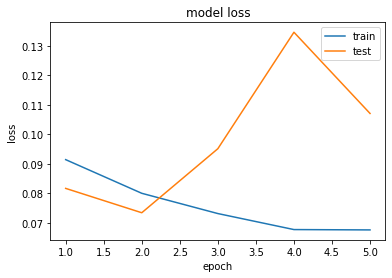

In [24]:
import matplotlib.pyplot as plt
plt.plot(range(1,6), train_epoch_loss)
plt.plot(range(1,6), test_epoch_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

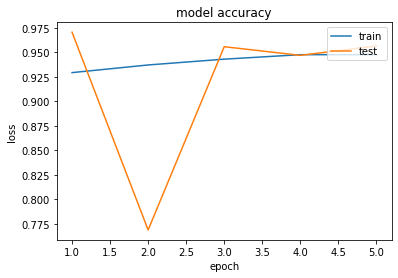

In [25]:
plt.plot(range(1,6), train_epoch_accuracy)
plt.plot(range(1,6), test_epoch_accuracy)
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

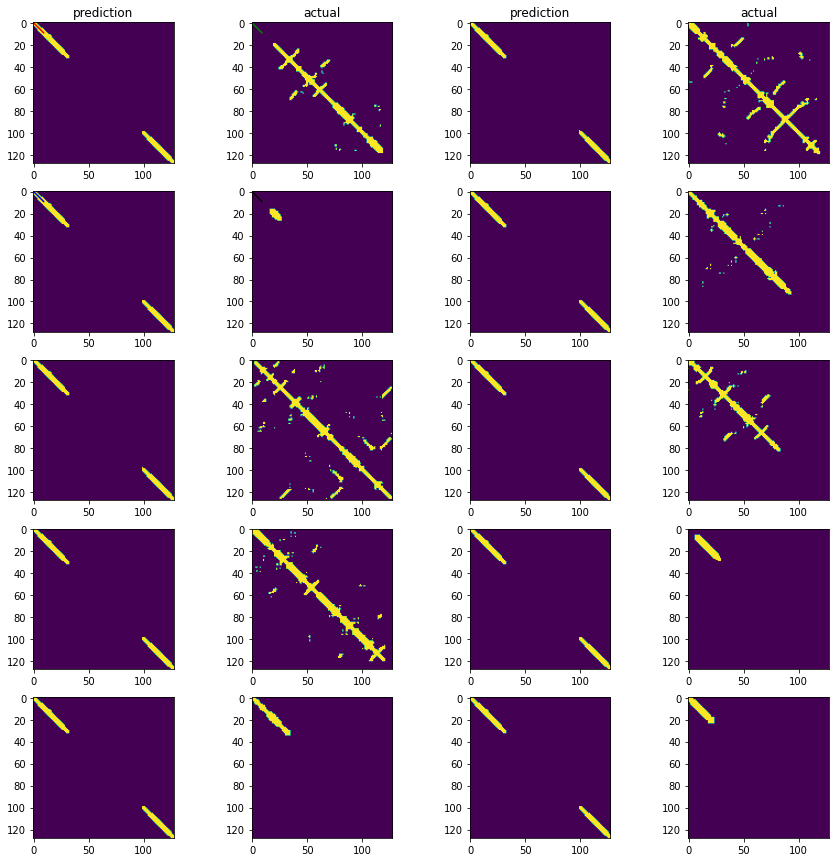

In [42]:
# predicted vs actual contact map plots
pred = np.where(predictions.numpy() > 0, 1, 0)
fig, ax = plt.subplots(5, 4, figsize=(15,15))

ax[0, 0].plot(range(10), 'r') #row=0, col=0
ax[1, 0].plot(range(10), 'b') #row=1, col=0
ax[0, 1].plot(range(10), 'g') #row=0, col=1
ax[1, 1].plot(range(10), 'k') #row=1, col=1
x, y = 0, 0
for i in range(10):
  ax[x//4, y%4].imshow(pred[i, :, :, 0])
  if x < 4:
    ax[x//4, y%4].title.set_text('prediction')
  x = x + 1
  y = y + 1
  ax[x//4, y%4].imshow(y_cmap[i, :, :, 0])
  if x < 4:
    ax[x//4, y%4].title.set_text('actual')
  x = x + 1
  y = y + 1
plt.show()

In [ ]:
# del 
import gc
gc.collect()